# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

**Desciption:** This projects aims to create a classifier for traffic signs.

---

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.

---
## Step 0: Importing Librarires

In [276]:
import cv2
import os
import glob
import pickle
import math
import random
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

---
## Step 1: Loading The Raw Data

In [277]:
## Raw Data Paths
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Loading Labels
label_list = []

with open('signnames.csv', 'r') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    next(readCSV)

    for row in readCSV:
        label_list.append(row[1])
        
## Number of Labels
nlabels = len(label_list)

print("Training data shape: " +str(X_train.shape))

Training data shape: (34799, 32, 32, 3)


---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'`: 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).  
- `'labels'`: 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.  
- `'sizes'`: A list containing tuples, (width, height) representing the original width and height the image.  
- `'coords'`: A list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**  

### Initial Checks

In [278]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("The image shape =", image_shape)
print("Number of classes (labels) =", n_classes)
print("Number of training images =", n_train)
print("Number of testing images =", n_test)


The image shape = (32, 32, 3)
Number of classes (labels) = 43
Number of training images = 34799
Number of testing images = 12630


**Note that** X_train only holds the 32x32x3 shape images!  
Corresponding labels are stored in y_train!

### Include an exploratory visualization of the dataset

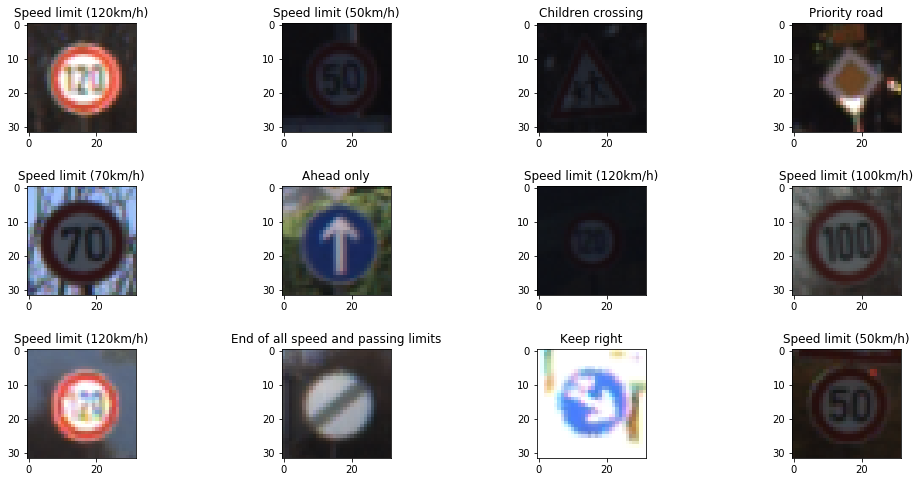

In [279]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Visualizing some random images with their labels
fig, ax = plt.subplots(3,4, figsize=(16,8))
fig.subplots_adjust(hspace = .5, wspace=1)
ax = ax.ravel()
for i in range(12):
    idx = random.randint(0, len(X_train))
    img = X_train[idx]
    ax[i].imshow(img)
    ax[i].set_title(label_list[y_train[idx]])

### Visualizing image class distributions

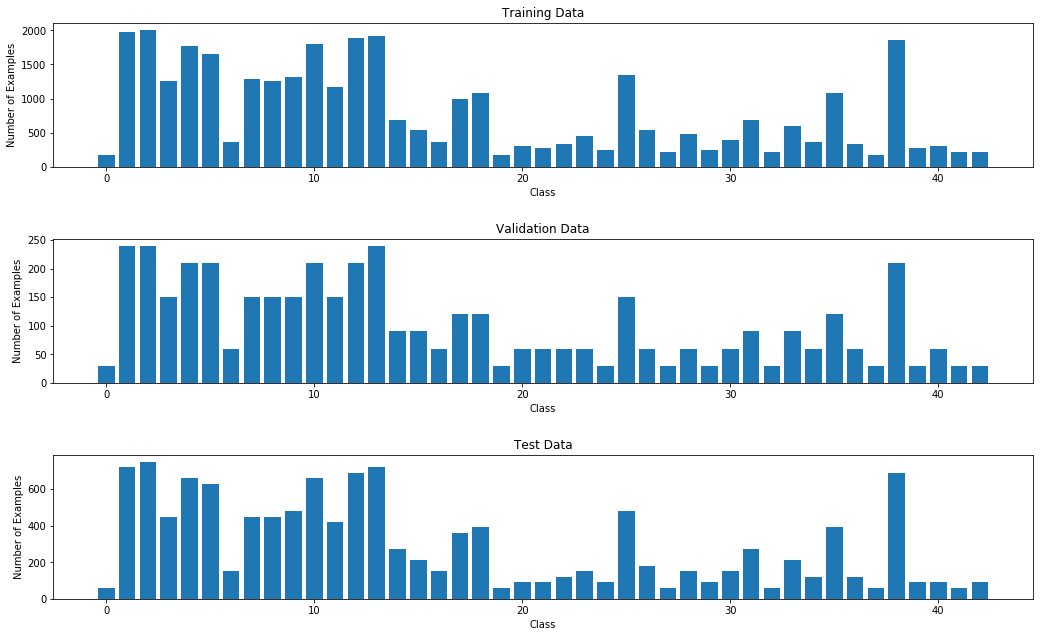

In [280]:
def plot_label_dist(labels,title):
    values, counts = np.unique(labels, return_counts=True)
    plt.bar(values, counts)
    plt.ylabel('Number of Examples')
    plt.xlabel('Class')
    plt.title(title)

plt.figure(figsize=(16, 16))
plt.subplots_adjust(top=1, bottom=0.5, left=0.10, right=0.95, hspace=0.5, wspace=0.01)
plt.subplot(311)
plot_label_dist(y_train,'Training Data')

plt.subplot(312)
plot_label_dist(y_valid,'Validation Data')

plt.subplot(313)
plot_label_dist(y_test,'Test Data')
plt.show()

The variation in the classes for the datasets (trainig, validation and test) seem similar to each other.

----

## Step 3: Pre-Processing the Image

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Creating the Pipeline for Initial Processing (For Better Features)

In [281]:
### Preprocess the data here. It is required to normalize the data.
### Other preprocessing steps could include converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def get_processed_img(img):
    img_norm = equalize_hist(img)
    img_sb = change_contrast(img_norm)
    img_aw = change_sharpness(img_sb)
    return img_aw

def equalize_hist(img):
    img2=img.copy() 
    img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img2

def change_contrast(img):
    #img*s+b
    img_s = cv2.multiply(img, np.array([0.5]))
    img_sb = cv2.add(img_s, np.array([254/4]))
    return img_sb

def change_sharpness(img):
    img_gb = cv2.GaussianBlur(img, (7,7), 20)
    img_aw = cv2.addWeighted(img, 2, img_gb, -1, 0)
    return img_aw

### Creating the Pipeline for Augmentation (For Increasing Amount of the Data)

In [282]:
def get_augmented_img(img, tra_range, rot_range, shr_range):
    '''
    In this function, the very basic image augmentation techniques are applied
    in order to use to increase the amount of the number of the images.
    These techniques are: translation, rotation and shearing the image.
    To do that OpenCv's warpAffine function is used,
    Ref:https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html
    '''
    ##Translation
    tra_x = tra_range*np.random.normal()-tra_range/2
    tra_y = tra_range*np.random.normal()-tra_range/2
    M_tra = np.float32([[1,0,tra_x], [0,1,tra_y]])
    
    ##Rotation
    rot_range = np.random.normal()-rot_range/2
    rows,cols,chns = img.shape
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),rot_range,1)
    
    ##Shearing
    lop,upp = rows/4, rows/1.6 #lower and upper points for the triangle
    #Coordinates of triangle vertices in the source image.
    src = np.float32([[lop,lop],[upp,lop],[lop,upp]])

    pt1 = lop+shr_range*np.random.normal()-shr_range/2
    pt2 = upp+shr_range*np.random.normal()-shr_range/2
    
    #Coordinates of the corresponding triangle vertices in the destination image.
    dst = np.float32([[pt1,lop],[pt2,pt1],[lop,pt2]])

    M_shr = cv2.getAffineTransform(src,dst)
        
    img = cv2.warpAffine(img,M_tra,(cols,rows))
    img = cv2.warpAffine(img,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_shr,(cols,rows))
    
    #Contranst change
    img_s = cv2.multiply(img, np.array([0.95]))
    img_sb = cv2.add(img_s, np.array([254/4]))
    
    return img_sb

### Visualizing the Pre-Processing Results

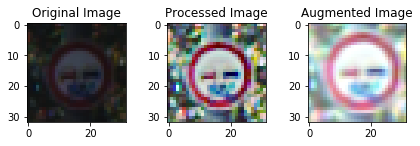

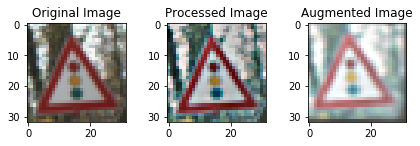

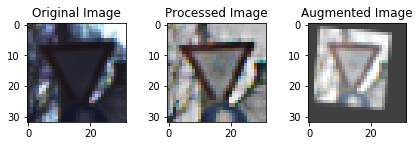

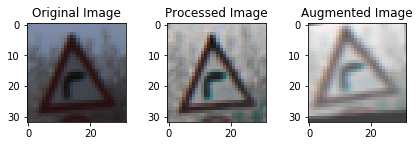

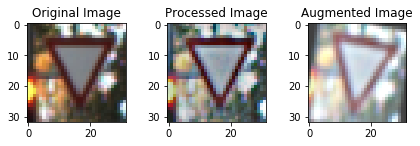

In [283]:
number_of_images = 5

for i in range(0,number_of_images):
    idx = random.randint(0, len(X_train))
    img = X_train[idx]
    img_pro = get_processed_img(img)
    img_aug = get_augmented_img(img_pro,1.2,5,1.2)
    
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(6,4))
    f.tight_layout()
    ax1.set_title('Original Image', fontsize=12)
    ax1.imshow(img)
    ax2.set_title('Processed Image', fontsize=12)
    ax2.imshow(img_pro)
    ax3.set_title('Augmented Image', fontsize=12)
    ax3.imshow(img_aug)
    plt.show()

### Creation of the Augmented Training Set

In [284]:
##No need to re-run if augmented datasets are created under the data folder!

X_train_aug = []
y_train_aug = []

for i in range(len(y_train)):
    img = X_train[i]
    img_aug=get_augmented_img(img,1.2,1.25,1.2)
    X_train_aug.append(img_aug)
    y_train_aug.append(y_train[i])
    
np.save('data/X_train_aug', X_train_aug)
np.save('data/y_train_aug', y_train_aug)

print('The augmented datasets have been saved!')

The augmented datasets have been saved!


In [285]:
with open('data/X_train_aug.npy', 'rb') as f1:
    X_train_aug = np.load(f1)

with open('data/y_train_aug.npy', 'rb') as f2:
    y_train_aug = np.load(f2)
    
X_train_aug.shape

(34799, 32, 32, 3)

In [286]:
print("Number of training set: " + str(X_train.shape[0]))
print("Number of augmented training set: " + str(X_train_aug.shape[0]))
print("Ratio between augmented and initial sets: " + str(X_train_aug.shape[0]/X_train.shape[0]))

Number of training set: 34799
Number of augmented training set: 34799
Ratio between augmented and initial sets: 1.0


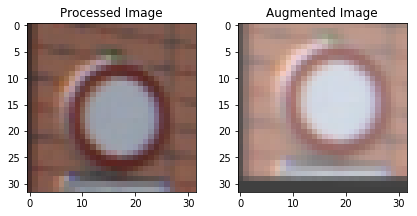

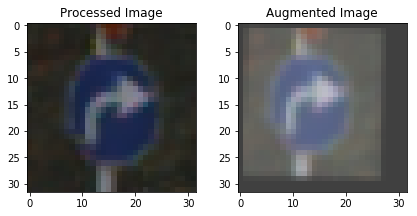

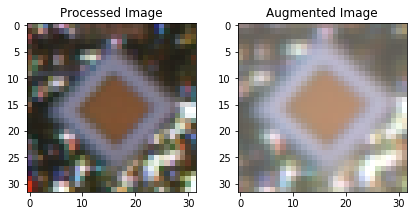

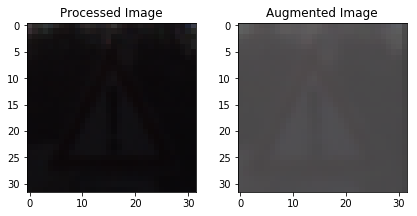

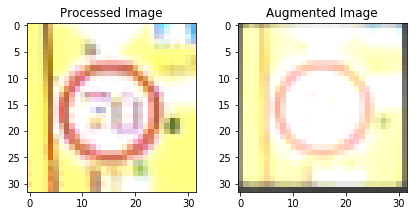

In [287]:
number_of_images = 5

for i in range(0,number_of_images):
    idx = random.randint(0, len(X_train))
    img = X_train[idx]
    img_aug = X_train_aug[idx]
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,4))
    f.tight_layout()
    ax1.set_title('Processed Image', fontsize=12)
    ax1.imshow(img)
    ax2.set_title('Augmented Image', fontsize=12)
    ax2.imshow(img_aug)
    plt.show()

In [288]:
## Combining 2 datasets (Original & Augmented)
X_train = np.concatenate((X_train, X_train_aug),axis=0)
y_train = np.concatenate((y_train, y_train_aug),axis=0)

In [289]:
print("Number of training images after augmentation: " +str(X_train.shape[0]))

Number of training images after augmentation: 69598


### Normalization and Grayscale Conversion of the Training and Test Sets

In [290]:
## Storing 5 random images for comparison after normalization
list_idx = []
list_img = []
number_of_images = 5

for i in range(0,number_of_images):
    idx = random.randint(0, len(X_train))
    list_idx.append(idx)
    list_img.append(X_train[idx])

In [291]:
def get_normalized(dataset):
    gray = np.mean(dataset, axis=3)
    gray_dim = np.expand_dims(gray, axis=3)
    img_norm = (gray_dim - gray_dim.mean())/gray_dim.std()
    
    return img_norm

In [292]:
X_train = get_normalized(X_train)
X_valid = get_normalized(X_valid)
X_test = get_normalized(X_test)

In [293]:
X_train.shape

(69598, 32, 32, 1)

### Data Partition into Training & Validation Sets

In [294]:
X_train, y_train = shuffle(X_train, y_train) #in order to eliminate the influence of the order!
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

----

## Step 4: Model Architecture

In [295]:
import tensorflow as tf

EPOCHS = 70
BATCH_SIZE = 100

![](img/lenet5.png)

Although I changed both learning and pre-processing parameters a lot, I could not exceed 86% validation accuracy with the original LeNet5 architecture.  
However, by modifying the last 2 FC layers in the architecture, the validation accuracy increased drastically!

See comments in the code below...

In [299]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Initial Arguments
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1,name='convolution0')
    conv1 = tf.nn.dropout(conv1, keep_prob2)

    # Pooling (Downsampling): Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution1')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # ReLU Activation.
    conv2 = tf.nn.relu(conv2, name='convolution2')

    # Pooling (Downsampling): Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution3')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Dropout_01    
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # ReLU Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 200. Output = 129.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 129), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(129))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    # ReLU Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout_02
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 129. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(129, 43), mean = mu, stddev = sigma, name='weights'))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [300]:
## The PLACEHOLDERS for Batch Input and Batch Output Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

### Train, Validate and Test the Model

- A validation set can be used to assess how well the model is performing.  
- A low accuracy on the training and validation sets imply underfitting.  
- A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Training Parameters

In [301]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

lrate = 0.0008

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lrate)
training_operation = optimizer.minimize(loss_operation)

#### Calculating the Accuracy

In [302]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0, keep_prob2:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Training Session

In [303]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Starting to train...")
    print()
    validation_accuracy_figure = []

    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.6, keep_prob2:0.7})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_figure.append(validation_accuracy)

        print("#EPOCH: {}".format(i+1))
        print("The Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './Traffic')
    print("The model has been saved!")

Starting to train...

#EPOCH: 1
The Validation Accuracy = 0.778

#EPOCH: 2
The Validation Accuracy = 0.861

#EPOCH: 3
The Validation Accuracy = 0.887

#EPOCH: 4
The Validation Accuracy = 0.902

#EPOCH: 5
The Validation Accuracy = 0.928

#EPOCH: 6
The Validation Accuracy = 0.920

#EPOCH: 7
The Validation Accuracy = 0.931

#EPOCH: 8
The Validation Accuracy = 0.945

#EPOCH: 9
The Validation Accuracy = 0.941

#EPOCH: 10
The Validation Accuracy = 0.950

#EPOCH: 11
The Validation Accuracy = 0.940

#EPOCH: 12
The Validation Accuracy = 0.954

#EPOCH: 13
The Validation Accuracy = 0.953

#EPOCH: 14
The Validation Accuracy = 0.951

#EPOCH: 15
The Validation Accuracy = 0.955

#EPOCH: 16
The Validation Accuracy = 0.960

#EPOCH: 17
The Validation Accuracy = 0.960

#EPOCH: 18
The Validation Accuracy = 0.965

#EPOCH: 19
The Validation Accuracy = 0.963

#EPOCH: 20
The Validation Accuracy = 0.966

#EPOCH: 21
The Validation Accuracy = 0.966

#EPOCH: 22
The Validation Accuracy = 0.964

#EPOCH: 23
The Vali

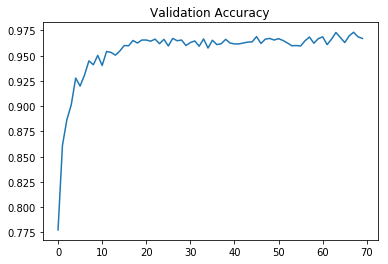

In [304]:
## Visualizing the Validation Accuracy
plt.plot(validation_accuracy_figure)
plt.title("Validation Accuracy")
plt.show()

In [305]:
## ACCURACY
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    #Printing the accuracy
    print("Training Accuracy = {:.3f}".format(train_accuracy))
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))
    print("Testing Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./Traffic
Training Accuracy = 0.989
Validation Accuracy = 0.967
Testing Accuracy = 0.952


---

## Step 5: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

(5, 32, 32, 1)


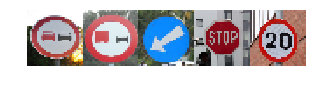

In [307]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob

fig, axs = plt.subplots(1,5, figsize=(5, 5))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./test_images/*.png')):
    image = cv2.imread(img)
    axs[i].axis('off')
    axs[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    my_images.append(image) 

my_images_normalized=get_normalized(my_images)
print(my_images_normalized.shape)

### Predict the Sign Type for Each Image

In [309]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
my_labels = [9,10,39,14,0]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./Traffic.meta')
    saver3.restore(sess, "./Traffic")
    my_accuracy = evaluate(my_images_normalized, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./Traffic
Test Set Accuracy = 1.000


### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./Traffic


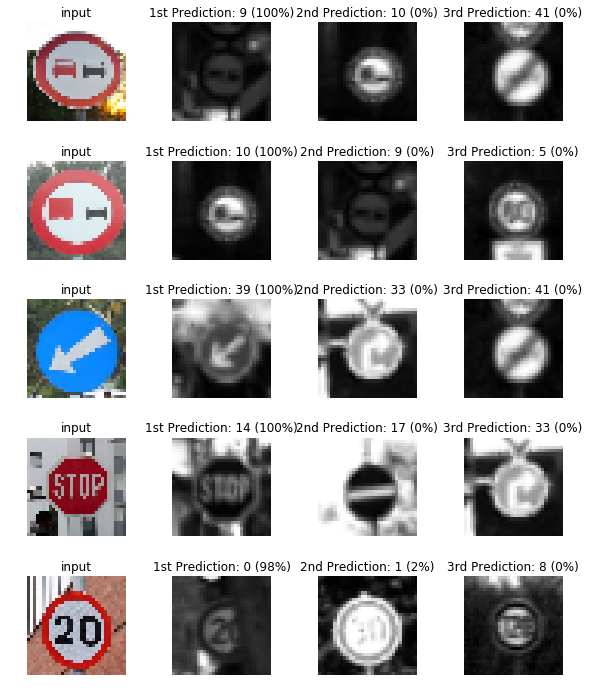

In [313]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=3)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph('./Traffic.meta')
    saver.restore(sess, "./Traffic")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_images_normalized, keep_prob: 1.0, keep_prob2:1.0})
    cur_top_k = sess.run(top_k, feed_dict={x: my_images_normalized, keep_prob: 1.0, keep_prob2:1.0})

    
    fig, axs = plt.subplots(len(my_images),4, figsize=(10, 12))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        pred1 = cur_top_k[1][i][0]
        idx1 = np.argwhere(y_valid == pred1)[0]
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_valid[idx1].squeeze(), cmap='gray')
        axs[4*i+1].set_title('1st Prediction: {} ({:.0f}%)'.format(pred1, 100*cur_top_k[0][i][0]))
        pred2 = my_top_k[1][i][1]
        idx2 = np.argwhere(y_valid == pred2)[0]
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_valid[idx2].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd Prediction: {} ({:.0f}%)'.format(pred2, 100*cur_top_k[0][i][1]))
        pred3 = my_top_k[1][i][2]
        idx3 = np.argwhere(y_valid == pred3)[0]
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_valid[idx3].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd Prediction: {} ({:.0f}%)'.format(pred3, 100*cur_top_k[0][i][2]))

### Analyzing The Performance

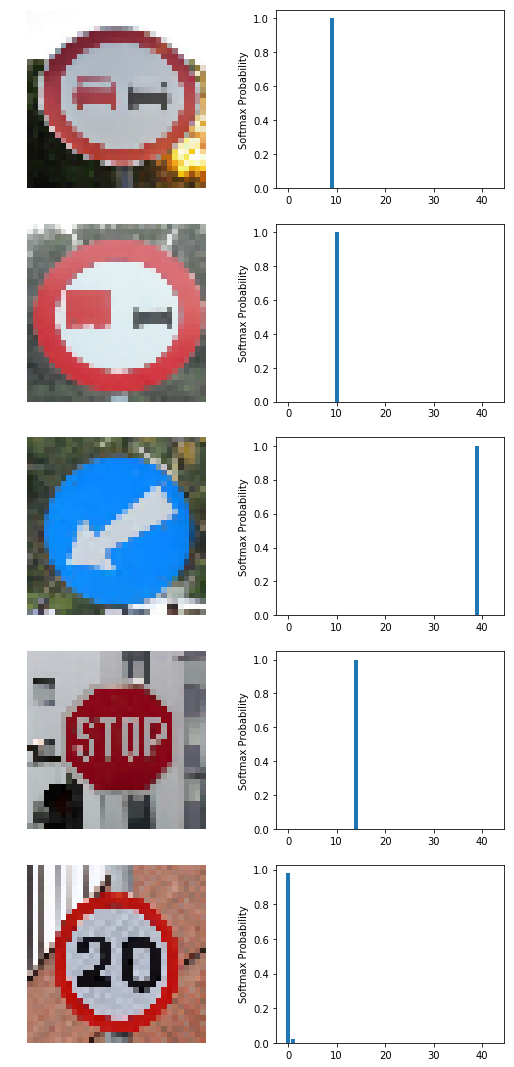

In [314]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
fig, axs = plt.subplots(5,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(len(my_softmax_logits)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax_logits[(i-1)//2]) 
        axs[i].set_ylabel('Softmax Probability')